<a href="https://colab.research.google.com/github/FBWeimer/sEMG/blob/main/preprocessing_EMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DOI: 10.1109/TNSRE.2020.3024947

References to pre-processing, extracted and numerated as paper:
    
[17] V. H. Cene and A. Balbinot, “Using the sEMG signal representativity
improvement towards upper-limb movement classification reliability,”
Biomed. Signal Process. Control, vol. 46, pp. 182–191, Sep. 2018.

[23] T. R. Farrell and R. F. Weir, “The optimal controller delay for myoelectric prostheses,” IEEE Trans.
Neural Syst. Rehabil. Eng., vol. 15, no. 1,pp. 111–118, Mar. 2007.

[24] T. R. Farrell, “Determining delay created by multifunctional prosthesis
controllers,” The J. Rehabil. Res. Develop., vol. 48, no. 6, pp. 21–37,
2011.

[29]  M. Atzori et al., “Characterization of a benchmark database for myoelectric movement classification,”
IEEE Trans. Neural Syst. Rehabil. Eng.,
vol. 23, no. 1, pp. 73–83, Jan. 2015. 

[30] V. Cene, M. Tosin, J. Machado, and A. Balbinot, “Open database
for accurate upper-limb intent detection using electromyography and
reliable extreme learning machines,” Sensors, vol. 19, no. 8, p. 1864,
Apr. 2019.

[31]  I. Kuzborskij, A. Gijsberts, and B. Caputo, “On the challenge
of classifying 52 hand movements from surface electromyography,” in Proc. Annu. Int. Conf. Eng. Med. Biol. Soc., Aug. 2012,
pp. 4931–4937.

In [3]:
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import stats
from numpy import savetxt
from scipy.io import loadmat
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPClassifier

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
def load_data(folder, database, subj, exerc, assay):
    """


    Parameters
    ----------
    folder : str
        FOLDER WHERE THE DATA IS SAVED.
    database : str
        NAME OF THE DATABASE.
    subj : int
        NUMBER OF THE SUBJECT IN DATABASE.
    exerc : int
        NUMBER OF THE EXERCISE IN DATABASE.
    assay : str
        TYPE OF ASSAY IN DATABASE (A, B, C or D)

    Returns
    -------
    emgRAWData : numpy.ndarray
        MATRIX WHERE COLUMNS ARE THE CHANNEL AND LINES ARE THE EMG RAW DATA IN TIME.
    labels : numpy.ndarray
        VECTOR CONTAINING THE LABEL OF EACH MOVEMENT.
    emgRAWData_df: pandas.core.frame.DataFrame
        DATAFRAME CONTAINING THE EMG RAW DATA AND LABELS

    """  
    
    path = (folder + '/' + database + 'S' + str(subj) + \
            '_'  + assay + str(exerc) + '.mat')
        
    allData = sio.loadmat(path)
    emgRAWData = np.double(allData['emg'])
    labels = np.double(allData['restimulus'])
    
    emgRAWData_df = pd.DataFrame(emgRAWData)
    emgRAWData_df.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
    emgRAWData_df['label'] = labels
    
    return emgRAWData_df

In [6]:
def removeNullData(emgData):
    """
    
    
    Parameters
    ----------
    emgData : pandas.core.frame.DataFrame
        DATAFRAME CONTAINING THE EMG RAW DATA AND LABELS.

    Returns
    -------
    emgData : pandas.core.frame.DataFrame
        DATAFRAME CONTAINING THE EMG DATA AND LABELS, WITHOUT NULLS VALUES.

    """

    
    print(emgData.isnull().all())
    emgData.apply(lambda x: x.fillna(x.mean(), inplace=True))
    
    
    return emgData

In [7]:
def avt_filter(emgData):
    """
    

    Parameters
    ----------
    emgData : pandas.core.frame.DataFrame
        DATAFRAME CONTAINING THE EMG DATA AND LABELS.

    Returns
    -------
    emg : pandas.core.frame.DataFrame
        DATAFRAME CONTAINING THE EMG FILTERED DATA AND LABELS.

    """
    
    
    """
    
    Anthonyan Verdan Transform (AVT) filter [17], [30]
    Statistical Filtering.
    
    """

    
    emg = emgData[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']].values
    label = emgData['label'].values
    
    ff1 = 0.8 # factor of moving average behavior of the filter
    ff2 = 0.2 # factor dynamic behavior of the filter
    
    sF = 2000 # sample frequency acquisition, 2-kHz
    
    tS = len(emg) # number of samples of EMG data
    
    twS = 300 #int(0.4*sF) - 1
    
    overlapS = 15 #int(0.01*sF)
    nCh = np.shape(emg)[1] # number of channels

    for i in range(0, tS, overlapS):
        
        if (i + twS) > tS:
            
            break
        
        for ch in range(nCh):
            
            # MAV(285 ms) = emg[i:i+twS-20, ch]
            # MAV(15 ms) =  emg[i+twS-20:i+twS, ch]
            
            MSA = (np.mean(emg[i:i+twS-overlapS, ch])*ff1 + np.mean(emg[i+twS-overlapS:i+twS, ch])*ff2)
            MSSD = (np.std(emg[i:i+twS-overlapS, ch])*ff1 + np.std(emg[i+twS-overlapS:i+twS, ch])*ff2)
            
            highLim = MSA + MSSD
            lowLim = MSA - MSSD
            
            filteredData = np.where(emg[i:i+twS, ch] < lowLim, MSA, emg[i:i+twS, ch])
            filteredData = np.where(filteredData > highLim, MSA, filteredData)
            
            emg[i:i+twS, ch] = filteredData
    
    emgData = pd.DataFrame(emg)
    emgData.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
    emgData['label'] = label
    
    return emgData

In [22]:
def feature_extraction(emgData): 
    
    """
    Statistical Filtering.
    """
    
    sF = 2000
    emg = emgData[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']].values
    tS = len(emg)
    overlapS = int(0.01*sF)
    twS = int(0.4*sF) - 1
    nCh = np.shape(emg)[1] # number of channels
    lengthFeat = int(np.round(((tS-twS)/overlapS)))
    
    label = np.zeros((lengthFeat, 1))
    feat_rms = np.zeros((lengthFeat, 12))
    feat_std = np.zeros((lengthFeat, 12))
    feat_var = np.zeros((lengthFeat, 12))
    feat_mav = np.zeros((lengthFeat, 12))
    feat_DES = np.zeros((lengthFeat, 12))
    
    idx = 0   
    
    for i in range(0, tS-twS, overlapS):
        
        for ch in range(nCh):
            
            if ch==0:
                
                label[idx,0] = emgData[str(ch+1)][i:i+twS].mode()[0]
                
            else:    
                
                feat_rms[idx,ch] = np.sqrt(np.mean(np.square(emgData[str(ch+1)][i:i+twS].values)))
                feat_std[idx,ch] = emgData[str(ch+1)][i:i+twS].std()
                feat_var[idx,ch] = emgData[str(ch+1)][i:i+twS].var()
                feat_mav[idx,ch] = emgData[str(ch+1)][i:i+twS].mean()
                
        if idx==0:    
            
            a = feat_mav[idx,:] #np.mean(signal[i:i+twS, 1:nCh])
            b = np.ones((nCh))
            
        elif idx > 0 and idx < lengthFeat-2: 
            
            b = a
            a = feat_mav[idx,:]
            
        elif idx == lengthFeat-1:
            
            break
        

        c = np.concatenate(([a], [b]), axis=0)   
        pca = PCA(n_components=1)
        pca.fit(c)
        #print(pca.components_)
        feat_DES[idx,:] = pca.components_
        
        idx += 1    
    
    filtered_DES = moving_average(feat_DES)
    
    columns_list = ['label']
    for ch in range(1, 12+1): columns_list.append('RMS_'+str(ch))
    for ch in range(1, 12+1): columns_list.append('STD_'+str(ch))
    for ch in range(1, 12+1): columns_list.append('VAR_'+str(ch))
    for ch in range(1, 12+1): columns_list.append('MAV_'+str(ch))
    for ch in range(1, 12+1): columns_list.append('DES_'+str(ch))
    
    df_label = pd.DataFrame(label)
    df_RMS = pd.DataFrame(feat_rms)
    df_STD = pd.DataFrame(feat_std)
    df_VAR = pd.DataFrame(feat_var)
    df_MAV = pd.DataFrame(feat_mav)
    df_DES = pd.DataFrame(filtered_DES)
    
    dfEMG = pd.concat([df_label, df_RMS, df_STD, df_VAR, df_MAV, df_DES], axis=1)
    
    dfEMG.columns = columns_list
    
    
    return dfEMG

In [20]:
def moving_average(data):
    filtered_DES = np.zeros(np.shape(data))
    data = np.absolute(data)

    N=10
    for i in range(12):

        data_padded = np.pad(data[:,i], (N//2, N-1-N//2), mode='edge')
        filtered_DES[:,i] = np.convolve(data_padded, np.ones((N,))/N, mode='valid') 
        
    return filtered_DES

In [10]:
def status(string):
    
    print(' ')
    print('------------------------------------------------------')
    print(' ')
    print(string)
    print(' ')

In [18]:
def plot(dfEMG, title='sEMG signal'):
    
    df = dfEMG.loc[:, dfEMG.columns != 'label']
    sns.set()
    fig = plt.figure(figsize=(20, 10))
    plt.plot(df)
    fig.suptitle(title, fontsize=25)
    plt.xlabel('Samples [n]', fontsize=22)
    plt.ylabel('Amplitude (V)', fontsize=22)
    plt.legend(list(df), loc='best', ncol=3, title='Channels', title_fontsize=15, fontsize=15)
    plt.plot()

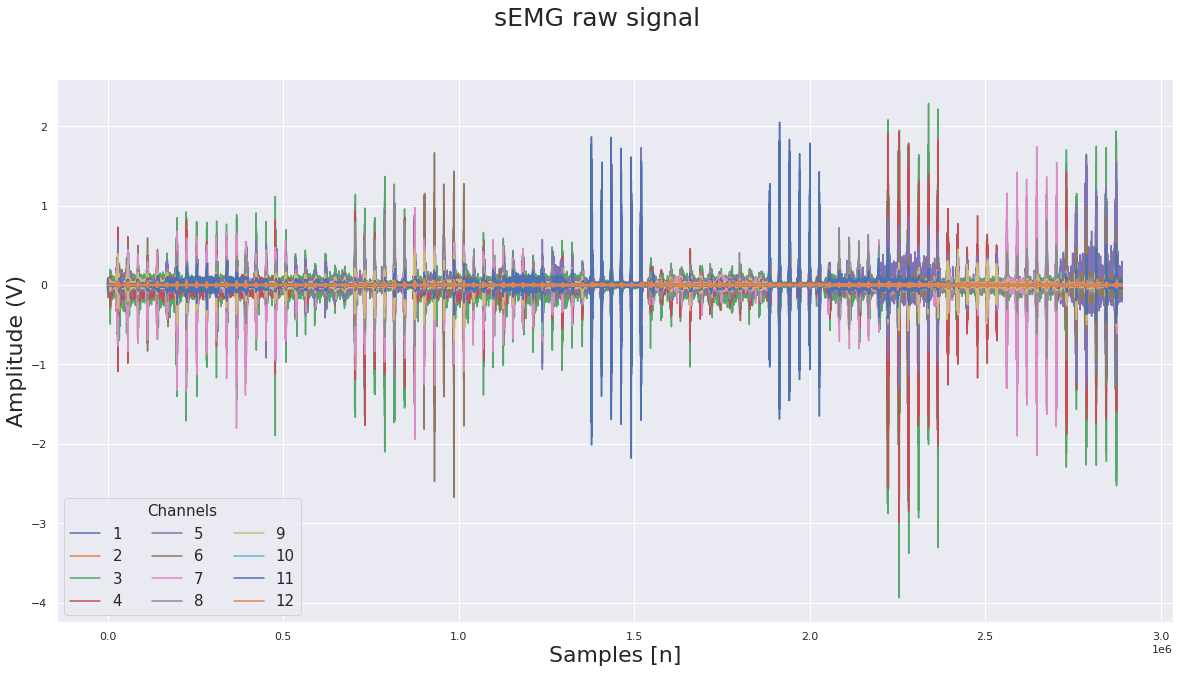

In [14]:
"""

PRE-PROCESSING MAIN FUNCTION

"""

# Declare path, database and exercise type
folder = '/content/drive/MyDrive/Bases de Dados'
database = 'Mão-Braço IEE/'
subj = '1'
exerc = '1'
assay = 'A'

# Load raw data and labels

dfEMGraw = load_data(folder, database, subj, exerc, assay)
plot(dfEMGraw, title='sEMG raw signal')

 
------------------------------------------------------
 
Occurence of null values in EMG Data:
 
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
label    False
dtype: bool
 
------------------------------------------------------
 
NULL VALUES RESOLVED
 


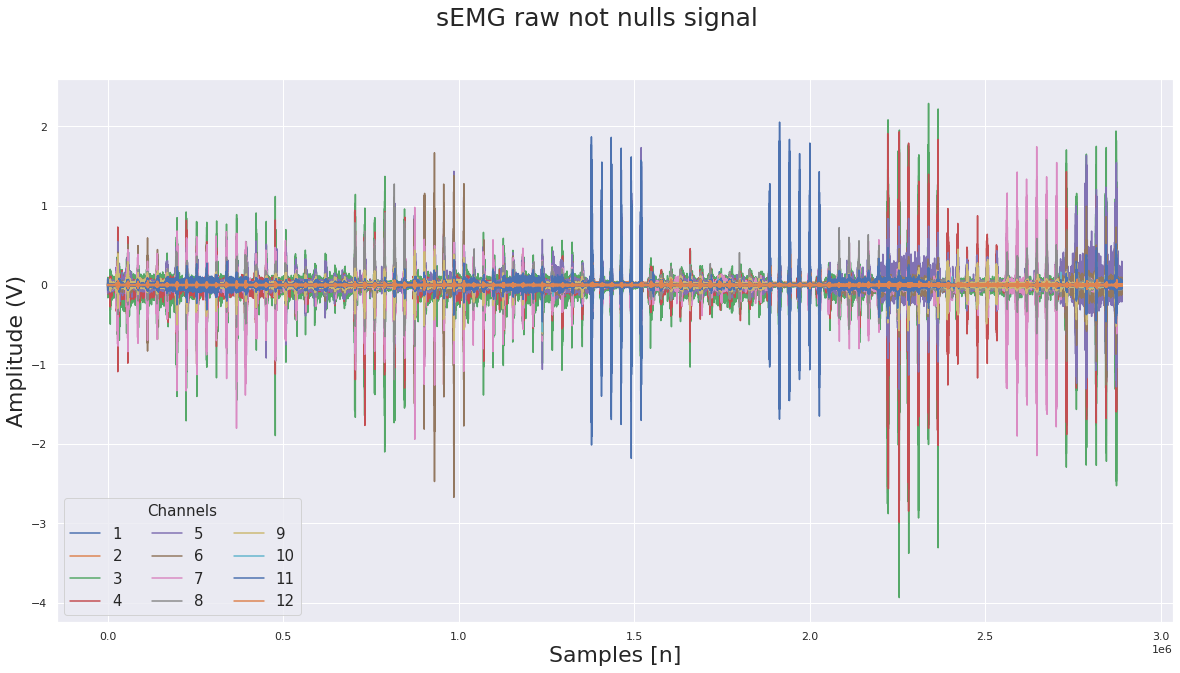

In [15]:
# Filtering null values in data

status('Occurence of null values in EMG Data:')
print(dfEMGraw.isnull().all())
dfEMGnull = dfEMGraw.apply(lambda x: x.fillna(x.mean()))
status('NULL VALUES RESOLVED')
dfEMGnull[[]]

plot(dfEMGnull, title='sEMG raw not nulls signal')

 
------------------------------------------------------
 
Calculating absolute values for  the EMG Data:
 
 
------------------------------------------------------
 
ABSOLUTE VALUES RESOLVED
 


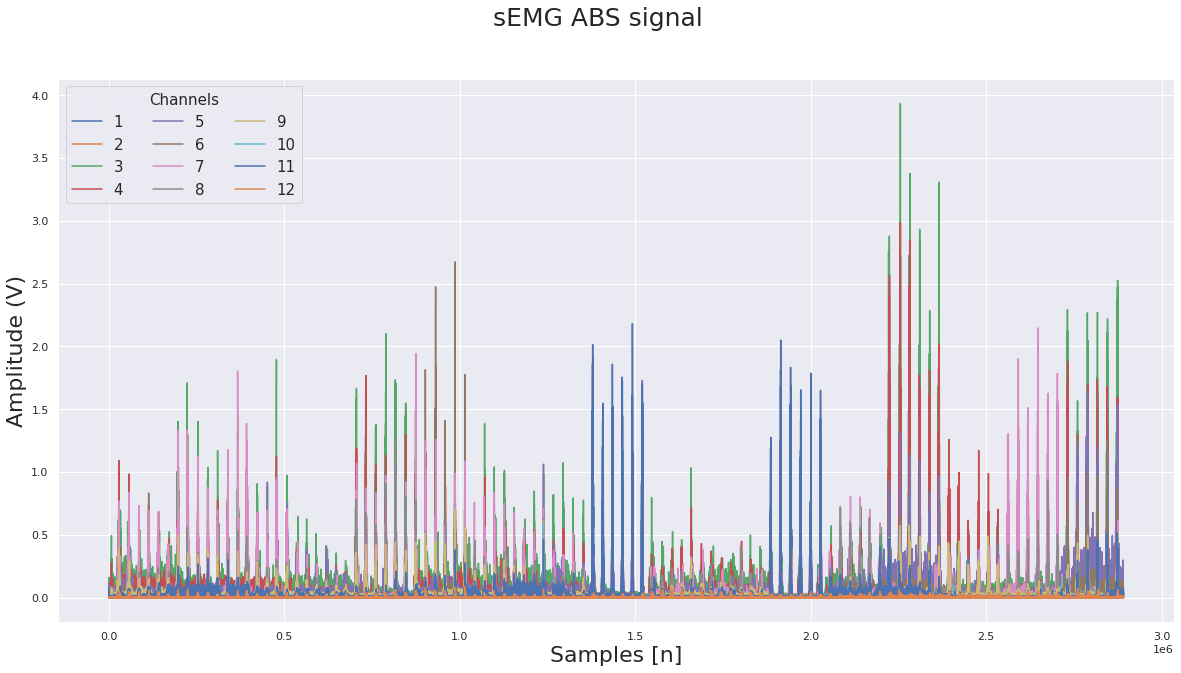

In [16]:
# Retify the data

status('Calculating absolute values for  the EMG Data:')
dfEMGabs = dfEMGnull.abs()
status('ABSOLUTE VALUES RESOLVED')

plot(dfEMGabs, title='sEMG ABS signal')

 
------------------------------------------------------
 
Applying AVT Filter to EMG Data:
 
 
------------------------------------------------------
 
AVT FILTER RESOLVED
 


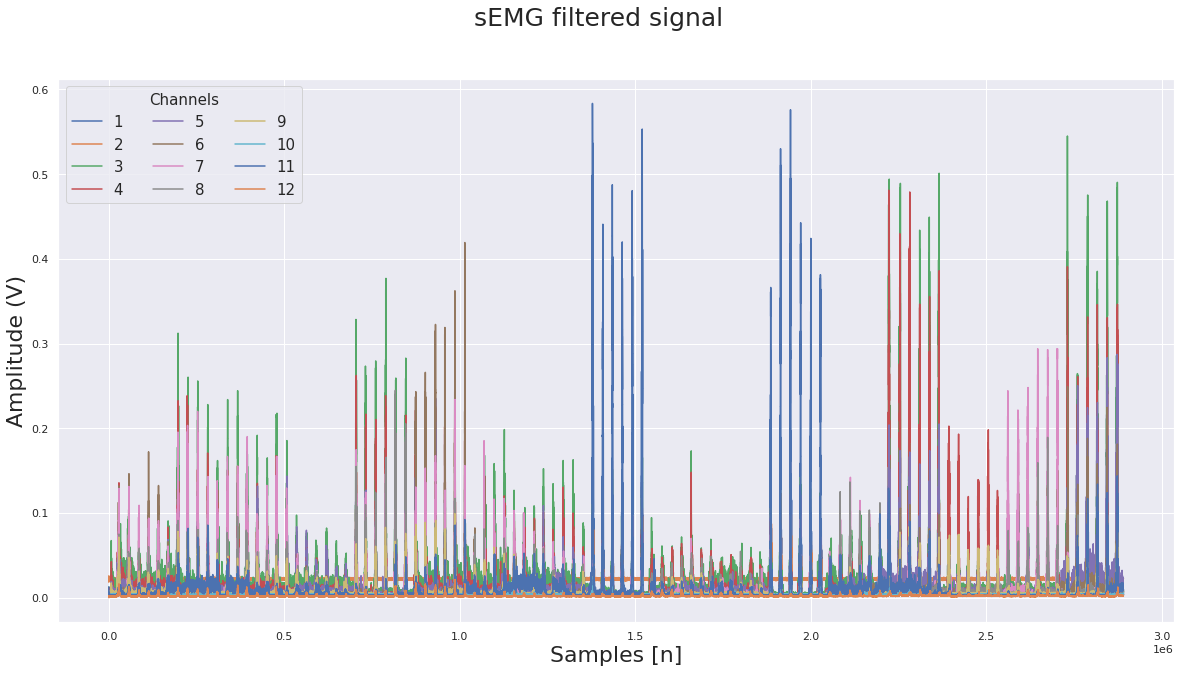

In [17]:
# Filter the data

status('Applying AVT Filter to EMG Data:')
dfEMGavt = avt_filter(dfEMGabs)
status('AVT FILTER RESOLVED')

plot(dfEMGavt, title='sEMG filtered signal')

 
------------------------------------------------------
 
Extracting features of EMG Data:
 
 
------------------------------------------------------
 
FEATURES EXTRACTED
 


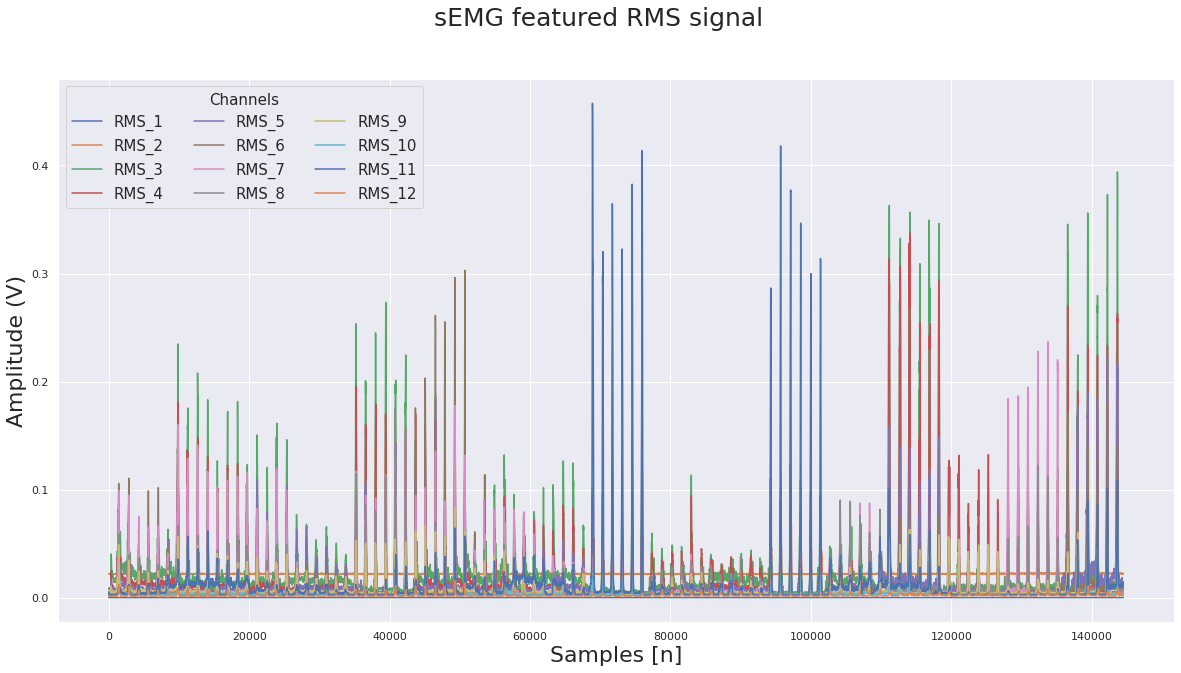

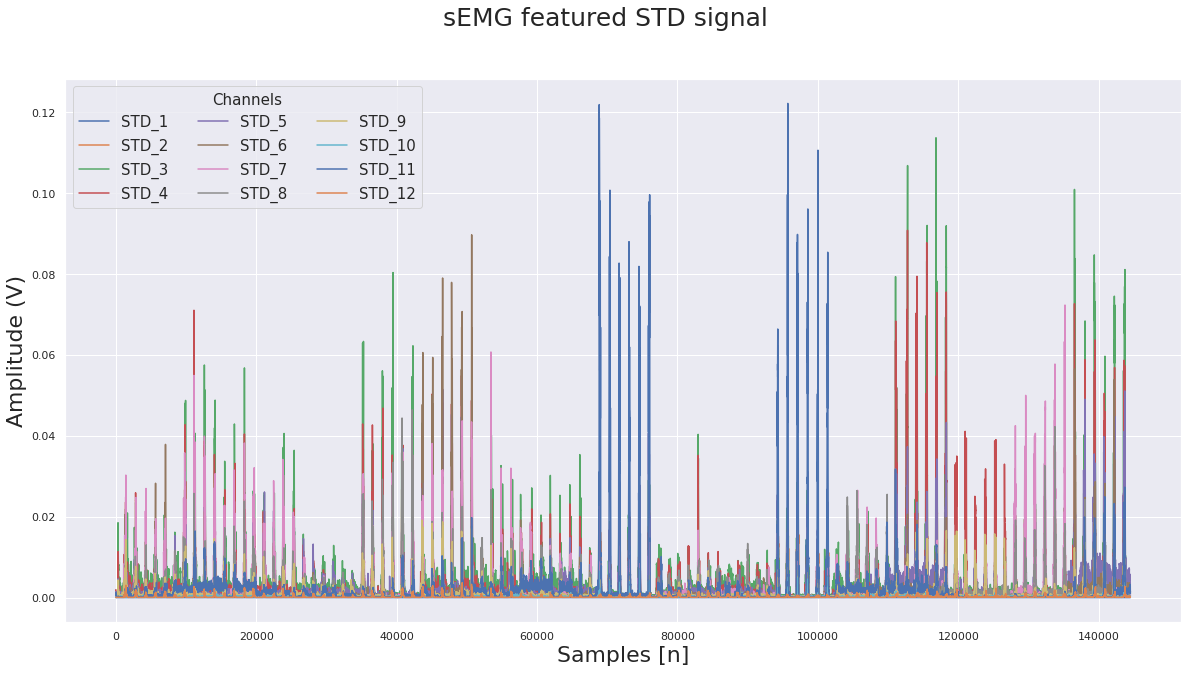

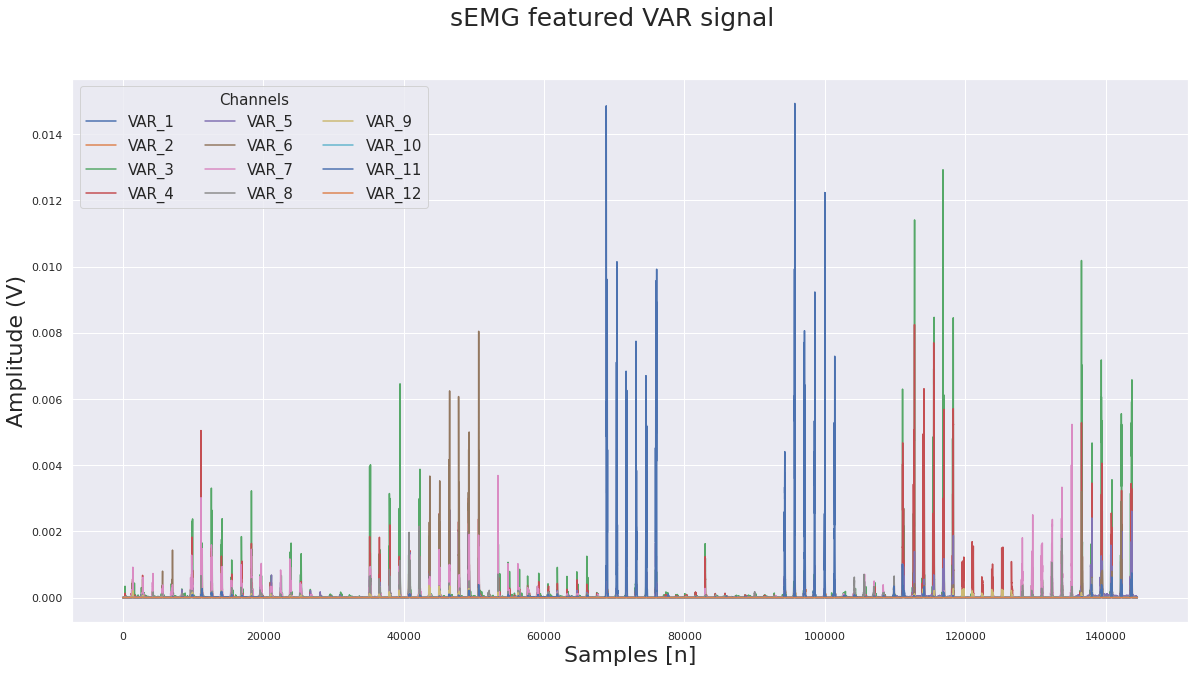

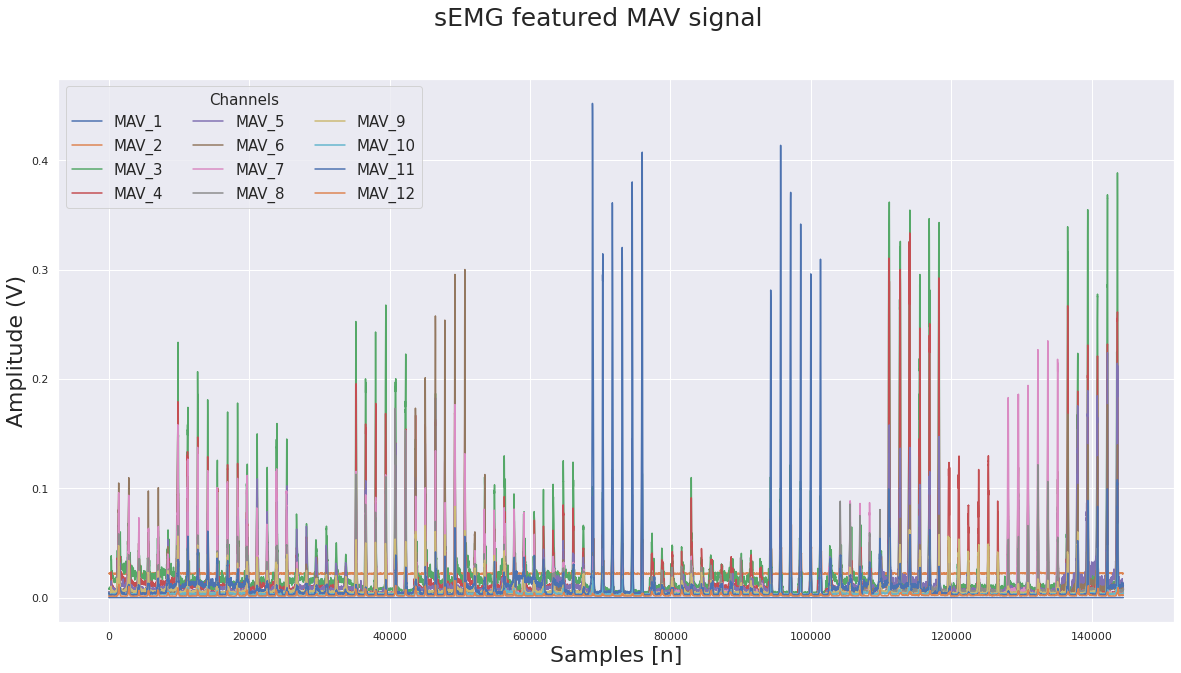

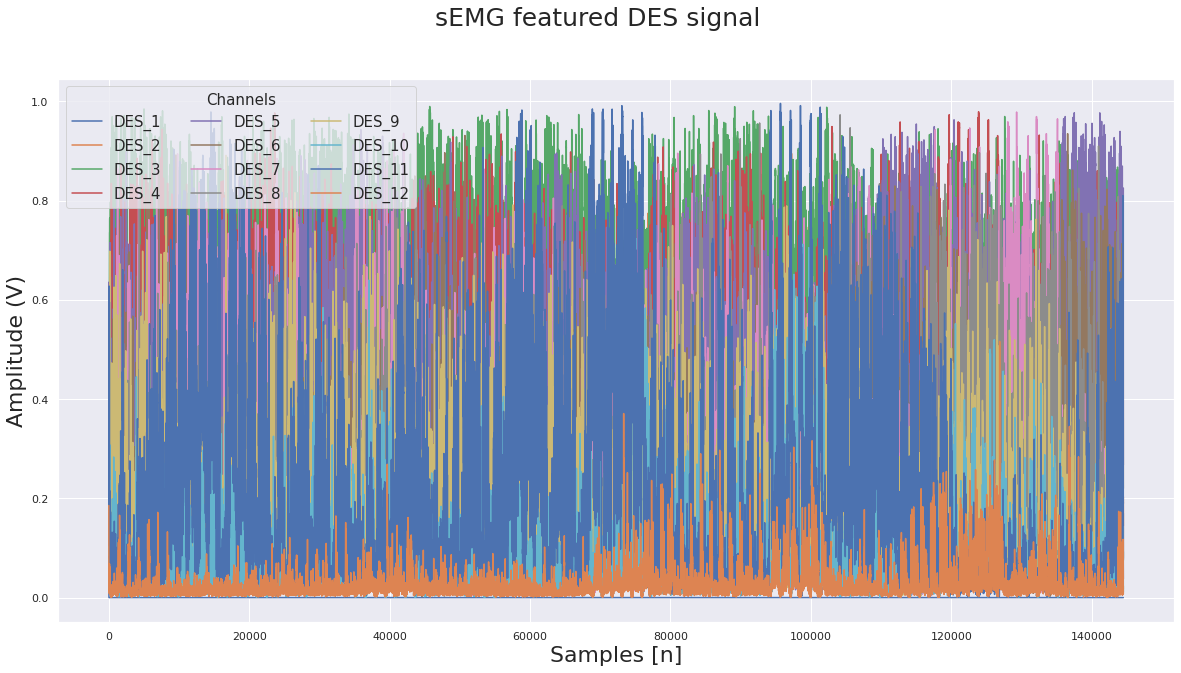

In [23]:
# Feature extraction

status('Extracting features of EMG Data:')
dfEMGfeat = feature_extraction(dfEMGavt)
status('FEATURES EXTRACTED')

features = ['RMS', 'STD', 'VAR', 'MAV', 'DES']

for feat in features:

  dfEMG = dfEMGfeat.filter(regex=feat).join(dfEMGfeat['label'])
  plot(dfEMG, title='sEMG featured '+ feat +' signal')

 
------------------------------------------------------
 
Normalizing EMG Data:
 
 
------------------------------------------------------
 
NORMALIZATION RESOLVED
 


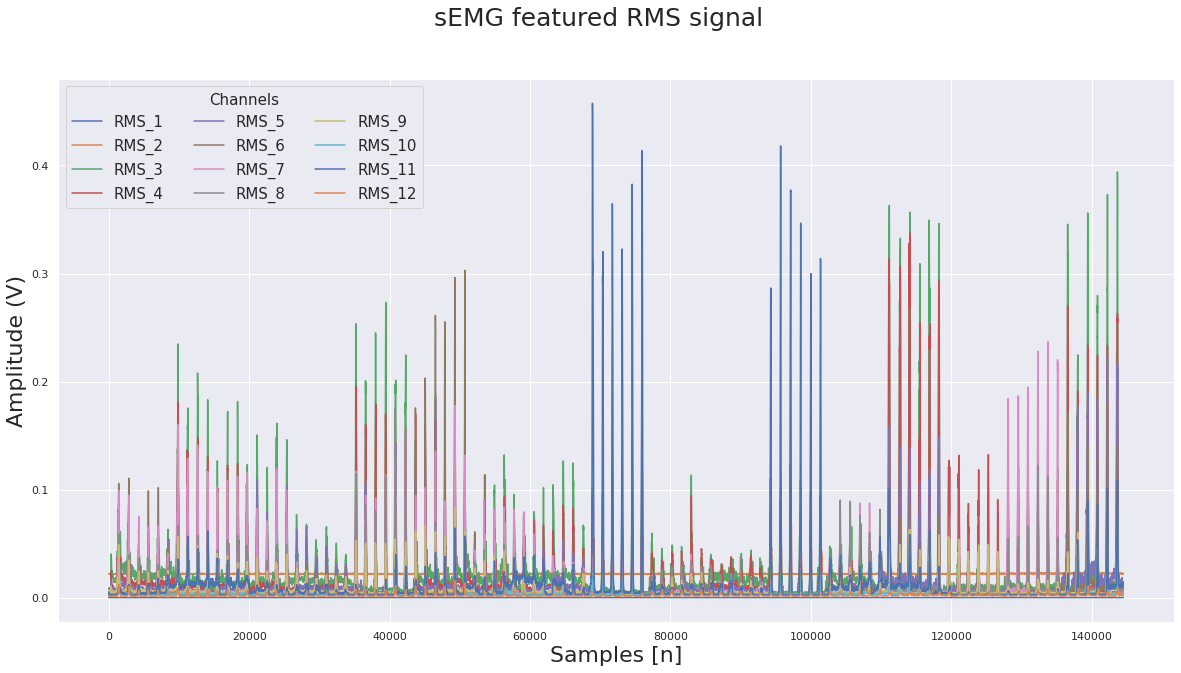

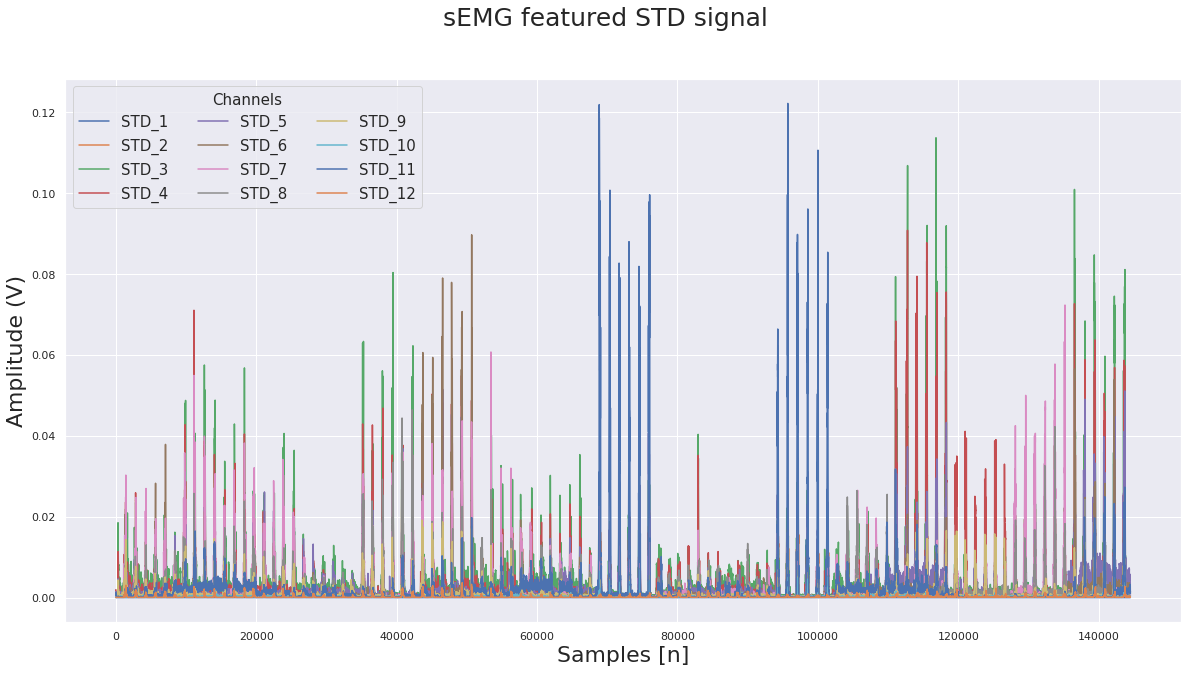

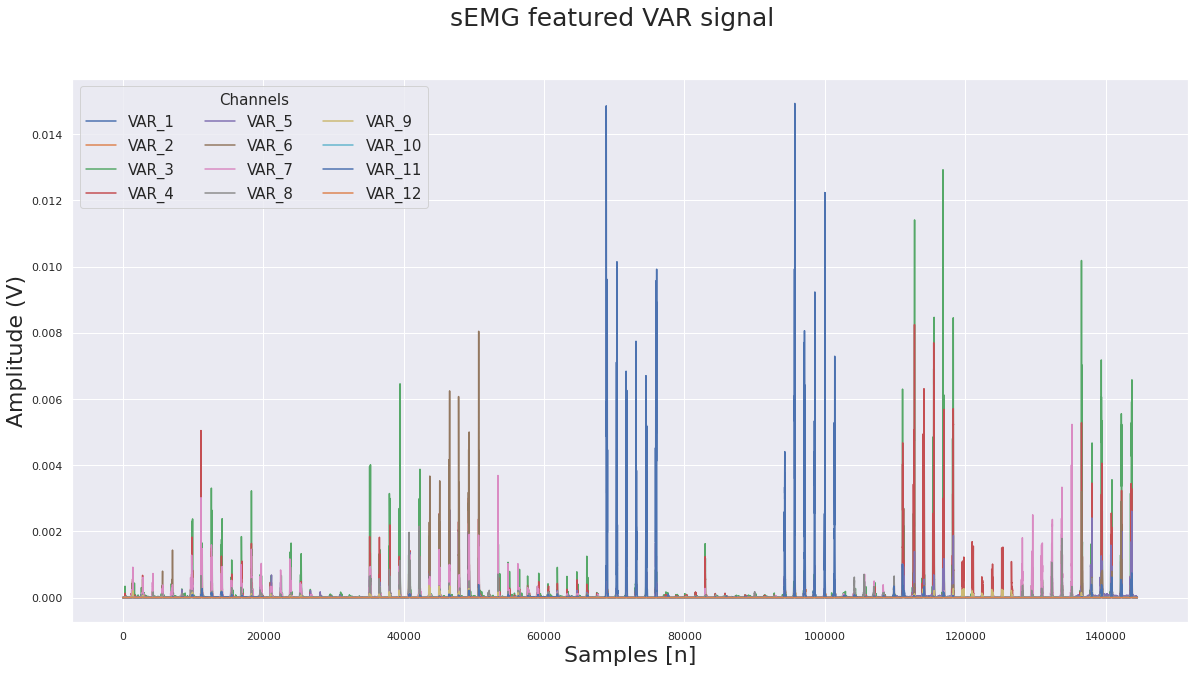

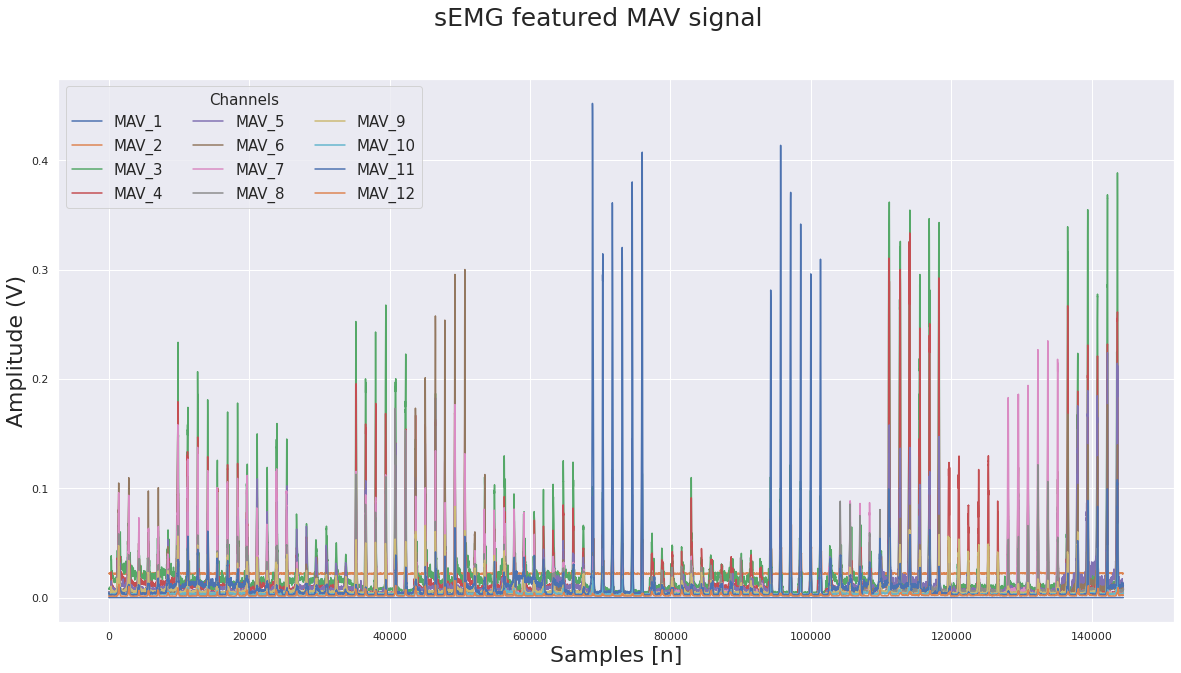

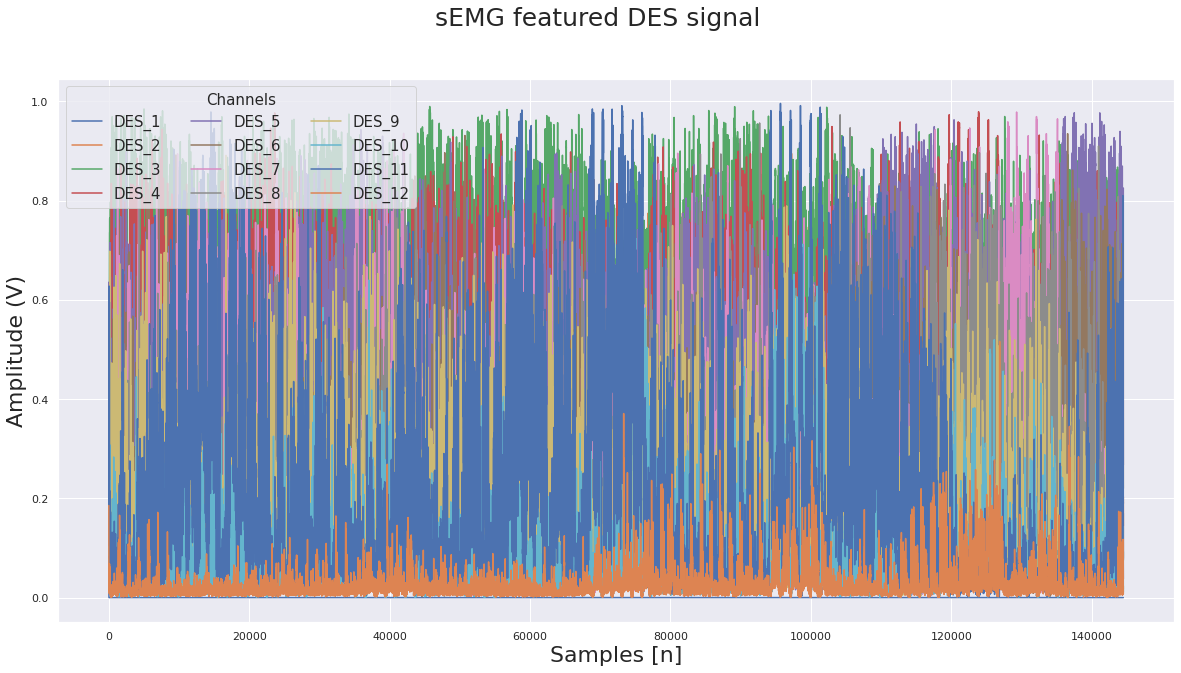

In [25]:
# Feature normalization

status('Normalizing EMG Data:')
dfEMGnorm = pd.DataFrame(normalize(dfEMGfeat))
status('NORMALIZATION RESOLVED')

features = ['RMS', 'STD', 'VAR', 'MAV', 'DES']

for feat in features:

  dfEMG = dfEMGfeat.filter(regex=feat).join(dfEMGfeat['label'])
  plot(dfEMG, title='sEMG featured '+ feat +' signal')